## Imports and settings

In [110]:
from os import *
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

In [ ]:
#forces CPU usage
environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
environ["CUDA_VISIBLE_DEVICES"] = "0" #"" for CPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

______________________________________-
## Data preprocessing

### Rain measurements
Measurements are downloaded from the DWD (German weather service) open data server: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/__<br>
I'm working with the data of August 2010 (based on [this](https://tradingeconomics.com/germany/precipitation)), so I have downloaded this: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/2010/RW-201008.tar__<br>
_DWD manual:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/BESCHREIBUNG_gridsgermany_hourly_radolan_historical_asc_de.pdf__<br><br>
This contains radar maps recorded in every hour. Each map has a resolution of $900\times900$ pixels and each pixel corresponds to an $1\,km\times1\,km$ area in reality. Pixel values are the precipitation height in $0.1\,mm$.
Below I'm importing the data of this as a series of numpy arrays and plot them to see the acual radar map. The _sys.path[0]_ is the path on my computer and it can be different for you.

In [ ]:
dataDir = sys.path[0]+"/rain"
files = listdir(dataDir)
files[0:5]

In [ ]:
totalLength = len(files)
#array of inputs
inputs = np.empty((totalLength,900,900))
print(inputs.shape)

In [ ]:
#import data to the inputs array
for i, file in enumerate(files):
    clear_output(wait=True)
    print(f"[{i+1}/{totalLength}]")
    ascii_grid = np.loadtxt(f"{dataDir}/{files[i]}", skiprows=6)
    inputs[i] = ascii_grid
    if i == 49:
        break

In [ ]:
%matplotlib notebook
from  matplotlib.animation import FuncAnimation

fig = plt.figure()
plot = plt.imshow(np.ma.masked_where(inputs[23] < 0, inputs[0]))
plt.colorbar()
plt.xlabel("Longitude pixels")
plt.ylabel("Latitude pixels")
def update(i):
    plot.set_data(np.ma.masked_where(inputs[23] < 0, inputs[i]))
    plt.title(f"Index in array: {i}\nDate: {files[i][9:11]}.{files[i][7:9]}.{files[i][3:7]} {files[i][12:14]}:{files[i][14:16]}")
    return plot

anim = FuncAnimation(fig, update, frames=20, interval = 200, blit=True, repeat=False)

plt.show()

### Radar coordinates
The gps coordinates of the radar grid for the rain measurements.

In [120]:
pre_lon = pd.read_table(sys.path[0]+"/rain_grid_coordinates/lambda_center.txt", header=None)
pre_lat = pd.read_table(sys.path[0]+"/rain_grid_coordinates/phi_center.txt", header=None)

In [125]:
#TODO
lon = pd.Series()
lat = pd.Series()
for idx, row in pre_lon.iterrows():
    lon = pd.concat((lon, pd.Series([row[i:i+8] for i in range(0, len(row), 8)])), axis=1)

In [124]:
lon

,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,NaN,0 03.5943203.6064703.6186203.6307603.642910...,0 03.5929603.6051103.6172603.6294103.641560...,0 03.5915903.6037403.6159003.6280503.640210...,0 03.5902303.6023803.6145403.6266903.638850...,0 03.5888603.6010203.6131803.6253403.637500...,0 03.5875003.5996603.6118203.6239803.636140...,0 03.5861303.5982903.6104503.6226203.634780...,0 03.5847603.5969303.6090903.6212603.633420...,0 03.5833903.5955603.6077303.6199003.632070...,...,0 02.0986702.1135902.1285102.1434302.158350...,0 02.0966002.1115302.1264502.1413702.156300...,0 02.0945302.1094602.1243802.1393102.154240...,0 02.0924602.1073902.1223202.1372502.152180...,0 02.0903802.1053202.1202502.1351902.150130...,0 02.0883102.1032502.1181902.1331202.148070...,0 02.0862302.1011702.1161202.1310602.146000...,0 02.0841602.0991002.1140502.1289902.143940...,0 02.0820802.0970302.1119802.1269302.141880...,0 02.0800002.0949502.1099002.1248602.139810...


### Wind measurements
Here I'm loading wind measurements. This is important because later we might experiment not only with rain (the density field) but with the wind (velocity field) too. This is because in the tempoGAN paper they also use the velocity and without it that might be very difficult to build the GAN (unless you have some other ideas). So for now I'll try this way. I have downloaded two datasets for the wind:<br><br>
_Wind direction:_ __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_direction/DD_201208.nc.gz__<br>
_Wind speed:_ __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_speed/FF_201208.nc.gz__<br>
_DWD manuals:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_direction/DESCRIPTION_gridsgermany_hourly_Project_TRY_wind_direction_en.pdf__
<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_speed/DESCRIPTION_gridsgermany_hourly_Project_TRY_wind_speed_en.pdf__<br><br>
I create two datasets out of these. They contain the $x$ and $y$ velocity components.
The measurements are in $\displaystyle0.1\,\frac{m}{s}$.
<br><br>
_<font color='red'>__Issue__:</font> [Mostly](https://www.nationalgeographic.com/science/earth/earths-atmosphere/clouds/) an average rain cloud is at $2000\,m$ high. Normal clouds can be up to $6000\,m$ high. We only have wind measurements recorded at $10\,m$. 
We can use e.g. [this](https://websites.pmc.ucsc.edu/~jnoble/wind/extrap/) to calculate wind speed at higher altitudes. We can't correct the change in wind direction so this remains a weak point in the simulations._

In [2]:
#the paths are probably different for you
w_dir = Dataset(sys.path[0]+'/wind_direction/DD_201008_CF.nc')  # direction
w_vel = Dataset(sys.path[0]+'/wind_speed/FF_201008_CF.nc')  # velocity

In [3]:
w_vel.variables.keys()

odict_keys(['Lambert_Conformal', 'X', 'Y', 'lon', 'lat', 'time', 'datum', 'FF'])

In [53]:
#creating vx and vy datasets
vx = w_vel['FF'][0]*np.sin(np.deg2rad(w_dir['DD'][0]))
vy = w_vel['FF'][0]*np.cos(np.deg2rad(w_dir['DD'][0]))

<IPython.core.display.Javascript object>


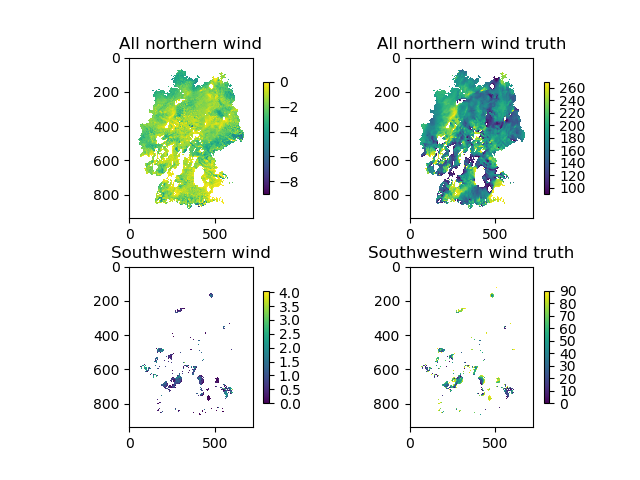

In [72]:
#sanity checks
%matplotlib notebook

# NE, N, NW
plt.subplot(2,2,1)
plt.imshow(np.flip(np.ma.masked_where(vy >0, vy), axis=0))
plt.colorbar(shrink=0.7)
plt.title("All northern wind")

plt.subplot(2,2,2)
plt.imshow(np.flip(np.ma.masked_where((w_dir['DD'][0]<90)| (w_dir['DD'][0]>270),w_dir['DD'][0] ), axis=0))
plt.colorbar(shrink=0.7)
plt.title("All northern wind truth")

# SW
plt.subplot(2,2,3)
plt.imshow(np.flip(np.ma.masked_where((vx<0)|(vy<0), vy), axis=0))
plt.colorbar(shrink=0.7)
plt.title("Southwestern wind")

plt.subplot(2,2,4)
plt.imshow(np.flip(np.ma.masked_where((w_dir['DD'][0]>90)| (w_dir['DD'][0]>360),w_dir['DD'][0] ), axis=0))
plt.colorbar(shrink=0.7)
plt.title("Southwestern wind truth")

plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Architecture
This is a toy network.

In [ ]:
D = keras.Sequential()
depth = 2
dropout = 0.4

conv1 = keras.layers.Conv2D(filters=depth*1 ,kernel_size=10, strides=5, input_shape=(900,900,1), padding='same')
relu1 = keras.layers.LeakyReLU(alpha=0.2)
dropout1 = keras.layers.Dropout(dropout)

conv2 = keras.layers.Conv2D(filters=depth*2, kernel_size=10, strides=5, padding='same')
relu2 = keras.layers.LeakyReLU(alpha=0.2)
dropout2 = keras.layers.Dropout(dropout)

conv3 = keras.layers.Conv2D(filters=depth*4, kernel_size=6, strides=2, padding='same')
relu3 = keras.layers.LeakyReLU(alpha=0.2)
dropout3 = keras.layers.Dropout(dropout)

conv4 = keras.layers.Conv2D(filters=depth*8, kernel_size=2, strides=2, padding='same')
relu4 = keras.layers.LeakyReLU(alpha=0.2)
dropout4 = keras.layers.Dropout(dropout)

# Out: 1-dim probability
flatten = keras.layers.Flatten()
fcl1 = keras.layers.Dense(1)
sig1 = keras.layers.Activation('sigmoid')
#summary()
D.add(conv1)
D.add(relu1)
D.add(dropout1)
D.add(conv2)
D.add(relu2)
D.add(dropout2)
D.add(conv3)
D.add(relu3)
D.add(dropout3)
D.add(conv4)
D.add(relu4)
D.add(dropout4)
D.add(flatten)
D.add(fcl1)
D.add(sig1)
D.summary()

In [ ]:
G = keras.Sequential()
dropout = 0.4
depth = 32
dim = 9
        # In: 100
        # Out: dim x dim x depth
G.add(keras.layers.Dense(dim*dim*depth, input_dim=100))
G.add(keras.layers.BatchNormalization(momentum=0.9))
G.add(keras.layers.Activation('relu'))
G.add(keras.layers.Reshape((dim, dim, depth)))
G.add(keras.layers.Dropout(dropout))

G.add(keras.layers.UpSampling2D(size=(2, 2)))
G.add(keras.layers.Conv2DTranspose(int(depth/2), 5, padding='same'))
G.add(keras.layers.BatchNormalization(momentum=0.9))
G.add(keras.layers.Activation('relu'))

G.add(keras.layers.UpSampling2D(size=(2, 2)))
G.add(keras.layers.Conv2DTranspose(int(depth/4), 5, padding='same'))
G.add(keras.layers.BatchNormalization(momentum=0.9))
G.add(keras.layers.Activation('relu'))

G.add(keras.layers.UpSampling2D(size=(5, 5)))
G.add(keras.layers.Conv2DTranspose(int(depth/8), 5, padding='same'))
G.add(keras.layers.BatchNormalization(momentum=0.9))
G.add(keras.layers.Activation('relu'))

G.add(keras.layers.UpSampling2D(size=(5, 5)))
G.add(keras.layers.Conv2DTranspose(1, 5, padding='same'))
G.add(keras.layers.Activation('sigmoid'))
G.summary()

In [ ]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0001, decay=3e-8)
AM = keras.Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
AM.fit(train_val_inputs,
          train_val_targets,
          batch_size = 50,
          epochs=50,
          validation_split = 0.1,
          shuffle = True)